# Example 1

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.genmod.families.links import Log
import matplotlib.pyplot as plt

In [2]:
def simulate_data(n=500, seed=0):
    """Simulate heteroscedastic Gaussian data:
       mu = beta0 + beta1 * x,  log phi = gamma0 + gamma1 * z,  y = mu + epsilon,  epsilon ~ N(0,phi)."""
    rng = np.random.RandomState(seed)
    x = rng.uniform(0, 10, size=n)
    z = rng.uniform(0, 10, size=n)
    beta0, beta1 = 1.0, 2.0
    gamma0, gamma1 = -1.0, 0.3
    mu = beta0 + beta1 * x
    phi = np.exp(gamma0 + gamma1 * z)
    y = mu + rng.normal(scale=np.sqrt(phi))
    return pd.DataFrame({'y': y, 'x': x, 'z': z})

In [3]:
# Simulate data
df = simulate_data(n=500, seed=42)

In [4]:
def fit_dglm(data, max_iter=100, tol=1e-6, verbose=True):
    """
    Fit a double GLM:
      1) Fit mean: GLM(y ~ x)  with weights = 1/phi
      2) Fit dispersion: GLM(r2 ~ z),  r2 = squared Pearson residuals
    Repeat until parameter change < tol.
    Returns: (mean_results, disp_results)
    """
    # 1) Initial mean fit (ignore heteroscedasticity)
    X_mean = sm.add_constant(data['x'])
    mean_mod = sm.GLM(data['y'], X_mean, family=sm.families.Gaussian())
    mean_res = mean_mod.fit()

    # 2) Initial dispersion fit from squared residuals
    data['mu_hat'] = mean_res.fittedvalues
    r2 = (data['y'] - data['mu_hat'])**2
    X_disp = sm.add_constant(data['z'])
    disp_mod = sm.GLM(
        r2,
        X_disp,
        family=sm.families.Gamma(link=Log())
    )
    disp_res = disp_mod.fit()

    # Iterate until convergence
    for i in range(max_iter):
        # Update mean model with weights = 1/phi_hat
        data['phi_hat'] = disp_res.fittedvalues
        weights = 1.0 / data['phi_hat']
        mean_mod = sm.GLM(
            data['y'],
            X_mean,
            family=sm.families.Gaussian(),
            var_weights=weights
        )
        new_mean = mean_mod.fit()

        # Update dispersion model from new squared residuals
        data['mu_hat'] = new_mean.fittedvalues
        r2 = (data['y'] - data['mu_hat'])**2
        disp_mod = sm.GLM(
            r2,
            X_disp,
            family=sm.families.Gamma(link=Log())
        )
        new_disp = disp_mod.fit()

        # Convergence check
        delta_beta = np.abs(new_mean.params - mean_res.params).max()
        delta_gamma = np.abs(new_disp.params - disp_res.params).max()
        if verbose:
            print(f"Iter {i+1}: delta_beta={delta_beta:.2e}, delta_gamma={delta_gamma:.2e}")
        mean_res, disp_res = new_mean, new_disp
        if max(delta_beta, delta_gamma) < tol:
            if verbose:
                print(f"Converged after {i+1} iterations.")
            break
    else:
        print("Warning: DGLM did not converge within max_iter")

    return mean_res, disp_res

In [5]:
# Fit DGLM
mean_res, disp_res = fit_dglm(df, verbose=True)

Iter 1: delta_beta=6.02e-02, delta_gamma=3.05e-02
Iter 2: delta_beta=2.92e-04, delta_gamma=8.95e-05
Iter 3: delta_beta=1.12e-06, delta_gamma=3.40e-07
Iter 4: delta_beta=4.27e-09, delta_gamma=1.30e-09
Converged after 4 iterations.


In [6]:
# Summaries
print("Mean Model Summary:")
print(mean_res.summary())

print("\nDispersion Model Summary:")
print(disp_res.summary())

Mean Model Summary:
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  500
Model:                            GLM   Df Residuals:                      498
Model Family:                Gaussian   Df Model:                            1
Link Function:               Identity   Scale:                          1.0040
Method:                          IRLS   Log-Likelihood:                -809.13
Date:                Fri, 02 May 2025   Deviance:                       500.00
Time:                        10:01:07   Pearson chi2:                     500.
No. Iterations:                     3   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3198      0.089

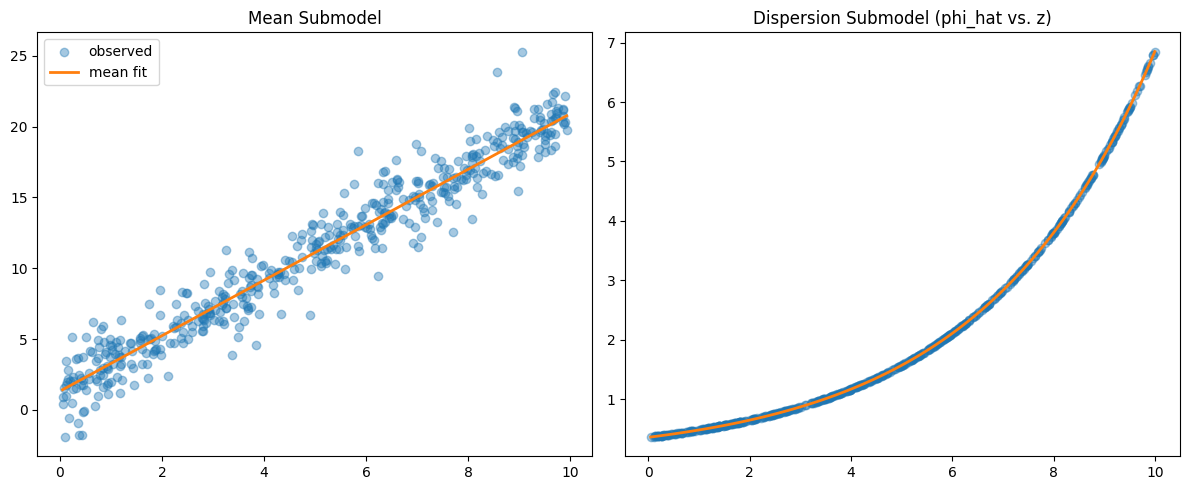

In [7]:
# Diagnostics
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ax = axes[0]
ax.scatter(df['x'], df['y'], alpha=0.4, label='observed')
x_line = np.linspace(df['x'].min(), df['x'].max(), 100)
y_line = mean_res.params['const'] + mean_res.params['x'] * x_line
ax.plot(x_line, y_line, color='C1', lw=2, label='mean fit')
ax.set_title("Mean Submodel")
ax.legend()

ax = axes[1]
ax.scatter(df['z'], disp_res.fittedvalues, alpha=0.4)
z_line = np.linspace(df['z'].min(), df['z'].max(), 100)
phi_line = np.exp(disp_res.params['const'] + disp_res.params['z'] * z_line)
ax.plot(z_line, phi_line, color='C1', lw=2)
ax.set_title("Dispersion Submodel (phi_hat vs. z)")

plt.tight_layout()
plt.show()

# Example 2

In [8]:
def simulate_data_nb(n=500, seed=0):
    """
    Simulate heteroscedastic Negative-Binomial count data via Gamma-Poisson mixture:
      log(mu)=beta0+beta1*x,
      log(theta)=gamma0+gamma1*z,
      lambda ~ Gamma(shape=theta, scale=mu/theta),
      y ~ Poisson(lambda).
    Returns DataFrame with columns y, x, z.
    """
    rng = np.random.RandomState(seed)
    x = rng.uniform(0, 10, size=n)
    z = rng.uniform(0, 10, size=n)
    beta0, beta1 = 0.5, 0.1
    gamma0, gamma1 = -1.0, 0.3
    eta_mu = beta0 + beta1 * x
    eta_disp = gamma0 + gamma1 * z
    mu = np.exp(eta_mu)
    theta = np.exp(eta_disp)
    # Gamma-Poisson mixture to generate NB counts
    lam = rng.gamma(shape=theta, scale=mu/theta)
    y = rng.poisson(lam)
    return pd.DataFrame({'y': y, 'x': x, 'z': z})

In [9]:
# Simulate NB data
df = simulate_data_nb(n=500, seed=42)

In [10]:
def fit_nb_dglm(data, max_iter=100, tol=1e-6, verbose=True):
    """
    Fit a Negative-Binomial Double GLM:
      1) Mean: GLM_NB(y ~ x) with var_weights = 1/alpha
      2) Dispersion: GLM_Gamma(r2 ~ z), r2 = Pearson^2 residuals
    Repeat until parameter changes < tol. Returns (mean_res, disp_res).
    """
    # Design matrices
    X_mean = sm.add_constant(data['x'])
    X_disp = sm.add_constant(data['z'])

    # 1) Initial mean fit (assume alpha_i = 1)
    mean_mod = sm.GLM(
        data['y'],
        X_mean,
        family=sm.families.NegativeBinomial(link=Log(), alpha=1.0)
    )
    mean_res = mean_mod.fit()

    # 2) Initial dispersion fit via Pearson residuals squared
    data['mu_hat'] = mean_res.fittedvalues
    # Variance for alpha=1: V = mu + mu^2
    V1 = data['mu_hat'] + data['mu_hat']**2
    pearson_sq = (data['y'] - data['mu_hat'])**2 / V1
    disp_mod = sm.GLM(
        pearson_sq,
        X_disp,
        family=sm.families.Gamma(link=Log())
    )
    disp_res = disp_mod.fit()

    # Iterative two-stage fitting
    for i in range(max_iter):
        # Update alpha estimates
        data['alpha_hat'] = disp_res.fittedvalues
        weights = 1.0 / data['alpha_hat']

        # Update mean model with var_weights = 1/alpha_hat
        mean_mod = sm.GLM(
            data['y'],
            X_mean,
            family=sm.families.NegativeBinomial(link=Log(), alpha=1.0),
            var_weights=weights
        )
        new_mean = mean_mod.fit()

        # Update dispersion model via new Pearson residuals
        data['mu_hat'] = new_mean.fittedvalues
        V1 = data['mu_hat'] + data['mu_hat']**2
        pearson_sq = (data['y'] - data['mu_hat'])**2 / V1
        disp_mod = sm.GLM(
            pearson_sq,
            X_disp,
            family=sm.families.Gamma(link=Log())
        )
        new_disp = disp_mod.fit()

        # Convergence check
        delta_beta = np.max(np.abs(new_mean.params - mean_res.params))
        delta_gamma = np.max(np.abs(new_disp.params - disp_res.params))
        if verbose:
            print(f"Iter {i+1}: d_beta={delta_beta:.2e}, d_gamma={delta_gamma:.2e}")
        mean_res, disp_res = new_mean, new_disp
        if max(delta_beta, delta_gamma) < tol:
            if verbose:
                print(f"Converged after {i+1} iterations.")
            break
    else:
        print("Warning: NB DGLM did not converge within max_iter")

    return mean_res, disp_res

In [11]:
# Fit NB double GLM
mean_res, disp_res = fit_nb_dglm(df, verbose=True)

Iter 1: d_beta=2.15e-02, d_gamma=6.37e-02
Iter 2: d_beta=8.00e-05, d_gamma=4.55e-04
Iter 3: d_beta=3.46e-07, d_gamma=1.98e-06
Iter 4: d_beta=1.50e-09, d_gamma=8.57e-09
Converged after 4 iterations.


In [12]:
# Summaries
print("--- NB Mean Submodel ---")
print(mean_res.summary())
print("\n--- NB Dispersion Submodel ---")
print(disp_res.summary())

--- NB Mean Submodel ---
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  500
Model:                            GLM   Df Residuals:                      498
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1574.8
Date:                Fri, 02 May 2025   Deviance:                       598.16
Time:                        10:01:08   Pearson chi2:                     500.
No. Iterations:                     6   Pseudo R-squ. (CS):             0.1012
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4425      

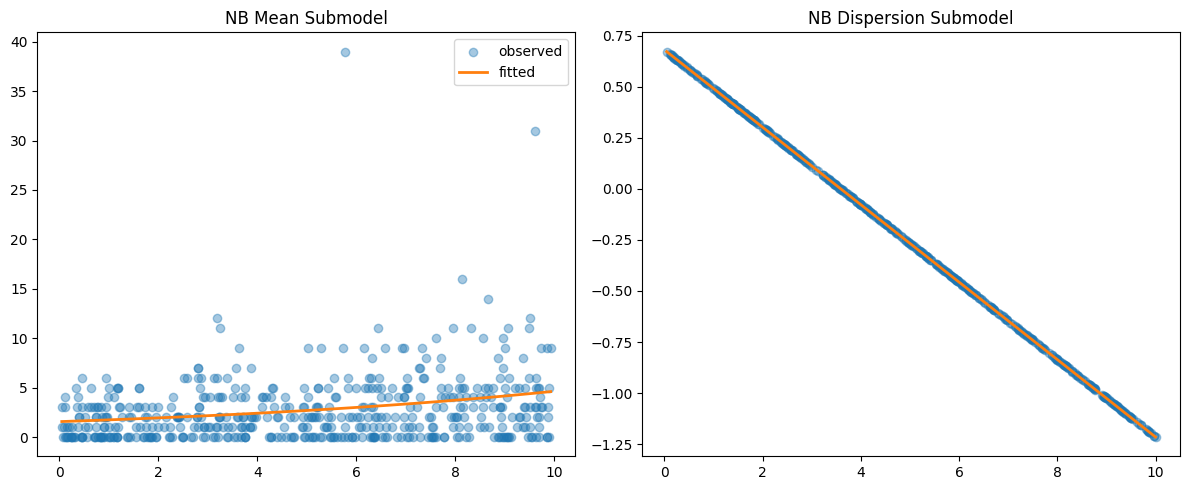

In [13]:
# Diagnostic plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Observed vs. fitted mean
ax = axes[0]
ax.scatter(df['x'], df['y'], alpha=0.4, label='observed')
xx = np.linspace(df['x'].min(), df['x'].max(), 100)
mu_line = np.exp(mean_res.params['const'] + mean_res.params['x'] * xx)
ax.plot(xx, mu_line, color='C1', lw=2, label='fitted')
ax.set_title('NB Mean Submodel')
ax.legend()

# Dispersion: log(alpha_hat) vs. z
ax = axes[1]
ax.scatter(df['z'], np.log(disp_res.fittedvalues), alpha=0.4)
zz = np.linspace(df['z'].min(), df['z'].max(), 100)
alpha_line = np.exp(disp_res.params['const'] + disp_res.params['z'] * zz)
ax.plot(zz, np.log(alpha_line), color='C1', lw=2)
ax.set_title('NB Dispersion Submodel')

plt.tight_layout()
plt.show()

# Example 3

In [14]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.genmod.families import Gaussian, Gamma
from statsmodels.genmod.families.links import Log
import matplotlib.pyplot as plt

In [15]:
def simulate_data(n=500, seed=0):
    """Simulate heteroscedastic Gaussian data:
       mu = beta0 + beta1 * x,
       log(phi) = gamma0 + gamma1 * z,
       y = mu + epsilon, epsilon ~ N(0,phi)."""
    rng = np.random.RandomState(seed)
    x = rng.uniform(0, 10, size=n)
    z = rng.uniform(0, 10, size=n)
    beta0, beta1 = 1.0, 2.0
    gamma0, gamma1 = -1.0, 0.3
    mu = beta0 + beta1 * x
    phi = np.exp(gamma0 + gamma1 * z)
    y = mu + rng.normal(scale=np.sqrt(phi))
    return pd.DataFrame({'y': y, 'x': x, 'z': z})

In [16]:
# Simulate the data
df = simulate_data(n=500, seed=42)

In [17]:
def fit_dglm_reml(data, max_iter=100, tol=1e-6, verbose=True):
    """
    Fit a Gaussian DGLM via approximate REML:

    Iteratively alternate:
      1) Mean step: IRLS GLM(y ~ x) with var_weights = 1/phi_i
      2) Dispersion step: Manual WLS on adjusted working vector and weights

    Returns:
      mean_res: GLMResults for the mean submodel
      gamma: ndarray of dispersion coefficients [gamma0, gamma1]
      phi_hat: final phi_i estimates
    """
    y = data['y'].values
    X_mean = sm.add_constant(data['x'])
    X_disp = sm.add_constant(data['z'])

    # Initial mean fit (ML)
    # GLM(y ~ x) with var_weights = 1/phi_hat
    mean_mod = sm.GLM(y, X_mean, family=Gaussian())
    mean_res = mean_mod.fit()
    mu_hat = mean_res.fittedvalues

    # Initial dispersion fit (ML)
    # Gamma–log GLM on unit deviance
    # Use Gamma(log) on d = (y-mu)^2 to get starting gamma, phi
    d = (y - mu_hat)**2
    disp_mod = sm.GLM(d, X_disp, family=Gamma(link=Log()))
    disp_res = disp_mod.fit()
    gamma = disp_res.params.copy()
    phi_hat = np.exp(X_disp @ gamma)

    # Alternate until convergence
    for iteration in range(1, max_iter+1):
        # Mean step
        w_mean = 1.0 / phi_hat
        mean_mod = sm.GLM(y, X_mean, family=Gaussian(), var_weights=w_mean)
        new_mean = mean_mod.fit()
        mu_hat = new_mean.fittedvalues

        # Compute hat-diagonals (leverages) h_i
        infl = new_mean.get_influence()
        h_diag = infl.hat_matrix_diag

        # Dispersion step (REML-adjusted WLS)
        # Unit deviance for Gaussian
        d = (y - mu_hat)**2

        # Original working vector z = (d - phi)/phi + log(phi)
        z_orig = (d - phi_hat)/phi_hat + np.log(phi_hat)
        # REML adjustment: z* = z_orig + h_i
        z_star = z_orig + h_diag

        # Original Wd = 1
        # Adjust: Wd* = 1 - 2 h_i
        w_star = 1.0 - 2.0 * h_diag

        # Solve WLS: (X' W* X) gamma = X' W* z*
        WX = X_disp * w_star[:, None]  # Each row of X_disp scaled by w_star[i]
        XtWX = WX.T @ X_disp
        XtWz = WX.T @ z_star
        new_gamma = np.linalg.solve(XtWX, XtWz)

        # Update phi
        new_phi = np.exp(X_disp @ new_gamma)

        # Check convergence
        delta_gamma = np.max(np.abs(new_gamma - gamma))
        delta_phi = np.max(np.abs(new_phi - phi_hat))
        if verbose:
            print(f"Iter {iteration}: Δgamma={delta_gamma:.2e}, Δphi={delta_phi:.2e}")

        gamma, phi_hat = new_gamma, new_phi
        mean_res = new_mean

        if delta_gamma < tol and delta_phi < tol:
            if verbose:
                print(f"Converged after {iteration} iterations.")
            break
    else:
        print("WARNING: DGLM–REML did not converge in max_iter iterations")

    return mean_res, gamma, phi_hat

In [18]:
# Fit DGLM via approximate-REML
mean_res, gamma, phi_hat = fit_dglm_reml(df, verbose=True)

Iter 1: Δgamma=1.97e-02, Δphi=9.54e-02
Iter 2: Δgamma=1.01e-03, Δphi=6.04e-03
Iter 3: Δgamma=5.01e-05, Δphi=3.38e-04
Iter 4: Δgamma=2.60e-06, Δphi=1.78e-05
Iter 5: Δgamma=1.36e-07, Δphi=9.28e-07
Converged after 5 iterations.


In [19]:
# Summaries
print("Mean Submodel Summary:")
print(mean_res.summary())
print("\nDispersion Summary:")
print(f"Intercept = {gamma[0]: .4f},  z = {gamma[1]: .4f}")

Mean Submodel Summary:
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  500
Model:                            GLM   Df Residuals:                      498
Model Family:                Gaussian   Df Model:                            1
Link Function:               Identity   Scale:                         0.99991
Method:                          IRLS   Log-Likelihood:                -809.13
Date:                Fri, 02 May 2025   Deviance:                       497.96
Time:                        10:01:09   Pearson chi2:                     498.
No. Iterations:                     3   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3197      0.

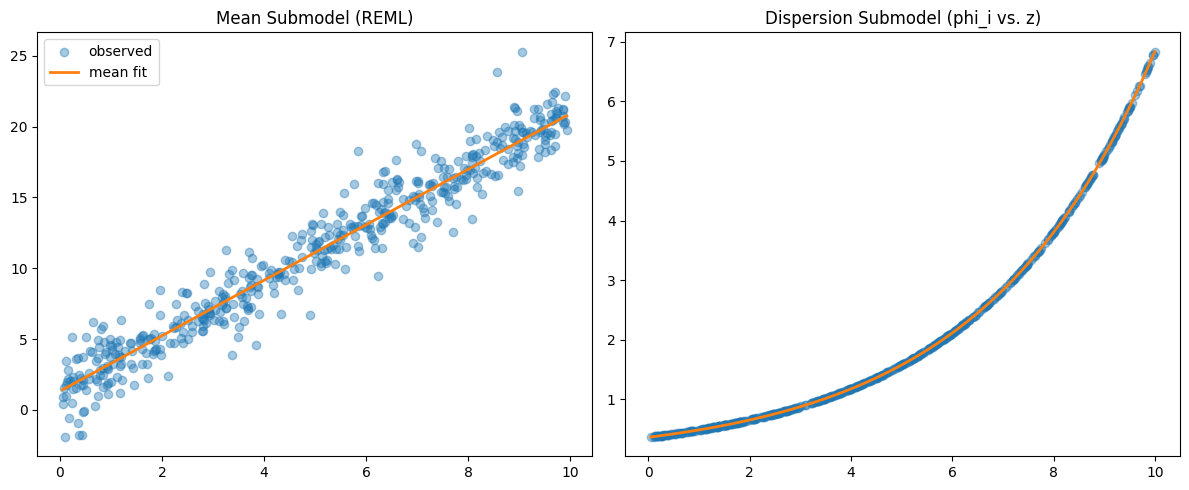

In [20]:
# Diagnostics plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Mean submodel
ax = axes[0]
ax.scatter(df['x'], df['y'], alpha=0.4, label='observed')
xx = np.linspace(df['x'].min(), df['x'].max(), 200)
yy = mean_res.params['const'] + mean_res.params['x']*xx
ax.plot(xx, yy, color='C1', lw=2, label='mean fit')
ax.set_title("Mean Submodel (REML)")
ax.legend()

# Dispersion submodel
ax = axes[1]
ax.scatter(df['z'], phi_hat, alpha=0.4)
zz = np.linspace(df['z'].min(), df['z'].max(), 200)
phi_line = np.exp(gamma[0] + gamma[1]*zz)
ax.plot(zz, phi_line, color='C1', lw=2)
ax.set_title("Dispersion Submodel (phi_i vs. z)")

plt.tight_layout()
plt.show()

# Example 4

In [21]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.genmod.families import NegativeBinomial, Gamma
from statsmodels.genmod.families.links import Log
import matplotlib.pyplot as plt

In [22]:
def simulate_data_nb(n=500, seed=0):
    """
    Simulate heteroscedastic NB counts via Gamma–Poisson:
      log(mu) = beta0 + beta1 * x
      log(theta) = gamma0 + gamma1 * z
      lambda ~ Gamma(shape=theta, scale=mu/theta)
      y ~ Poisson(lambda)
    """
    rng = np.random.RandomState(seed)
    x = rng.uniform(0, 10, size=n)
    z = rng.uniform(0, 10, size=n)
    beta0, beta1 = 0.5, 0.1
    gamma0, gamma1 = -1.0, 0.3
    mu = np.exp(beta0 + beta1 * x)
    theta = np.exp(gamma0 + gamma1 * z)
    lam = rng.gamma(shape=theta, scale=mu/theta)
    y = rng.poisson(lam)
    return pd.DataFrame({'y': y, 'x': x, 'z': z})

In [23]:
# Simulate NB data
df = simulate_data_nb(n=500, seed=42)

In [24]:
def deviance_nb(y, mu, alpha=1.0):
    """
    Unit deviance for NB with shape alpha:
      d_i = 2 [ y log(y/mu)
             - (y+alpha) log((y+alpha)/(mu+alpha)) ],
    with the y=0 special case d_i = 2*alpha*log((mu+alpha)/alpha).
    """
    y = np.asarray(y, dtype=float)
    mu = np.asarray(mu, dtype=float)
    d = np.zeros_like(mu)
    zero = (y == 0)
    if zero.any():
        d[zero] = 2 * alpha * np.log((mu[zero] + alpha) / alpha)
    pos = ~zero
    y_p, mu_p = y[pos], mu[pos]
    d[pos] = 2 * (
        y_p * np.log(y_p/mu_p)
        - (y_p+alpha) * np.log((y_p+alpha)/(mu_p+alpha))
    )
    return d

In [25]:
def fit_nb_dglm_reml(data, max_iter=100, tol=1e-6, verbose=True):
    """
    Fit NB DGLM via approximate REML:
      - Mean: NB GLM(y~x) with var_weights=1/phi_i
      - Dispersion: Manual WLS on unit deviance with REML corrections
    Returns (mean_results, gamma, phi_hat).
    """
    y = data['y'].values
    X_mean = sm.add_constant(data['x'])
    X_disp = sm.add_constant(data['z'])
    nb_family = NegativeBinomial(link=Log(), alpha=1.0)

    # Initial mean fit
    # NB GLM(y ~ x) with var_weights = 1/alpha_hat
    mean_mod = sm.GLM(y, X_mean, family=nb_family)
    mean_res = mean_mod.fit()
    mu_hat = mean_res.fittedvalues

    # Initial dispersion fit (ML)
    # Gamma–log GLM on NB unit deviance
    d = deviance_nb(y, mu_hat, alpha=1.0)
    disp_mod = sm.GLM(d, X_disp, family=Gamma(link=Log()))
    disp_res = disp_mod.fit()
    gamma = disp_res.params.copy()
    phi_hat = np.exp(X_disp @ gamma)

    # Iterate until convergence
    for iteration in range(1, max_iter+1):
        # Mean step with var_weights = 1/phi_i
        w_mean = 1.0 / phi_hat
        mean_mod = sm.GLM(y, X_mean, family=nb_family, var_weights=w_mean)
        new_mean = mean_mod.fit()
        mu_hat = new_mean.fittedvalues

        # Leverage (hat diagonal) from mean GLM
        h = new_mean.get_influence().hat_matrix_diag

        # Unit deviance
        d = deviance_nb(y, mu_hat, alpha=1.0)

        # REML-adjusted working vector and weights
        z_orig = (d - phi_hat)/phi_hat + np.log(phi_hat)
        z_star = z_orig + h
        w_star = 1.0 - 2.0*h

        # Manual WLS update for gamma
        WX = X_disp * w_star[:, None]
        XtWX = WX.T @ X_disp
        XtWz = WX.T @ z_star
        new_gamma = np.linalg.solve(XtWX, XtWz)
        new_phi = np.exp(X_disp @ new_gamma)

        # Check convergence
        dg = np.max(np.abs(new_gamma - gamma))
        dp = np.max(np.abs(new_phi - phi_hat))
        if verbose:
            print(f"Iter {iteration}: d_gamma={dg:.2e}, d_phi={dp:.2e}")

        gamma, phi_hat, mean_res = new_gamma, new_phi, new_mean

        if dg < tol and dp < tol:
            if verbose:
                print(f"Converged after {iteration} iterations.")
            break
    else:
        print("WARNING: NB DGLM (REML) did not converge within max_iter")

    return mean_res, gamma, phi_hat

In [26]:
# Fit NB DGLM via approximate REML
mean_res, gamma, phi_hat = fit_nb_dglm_reml(df, verbose=True)

Iter 1: d_gamma=7.32e-03, d_phi=1.47e-02
Iter 2: d_gamma=1.27e-04, d_phi=2.54e-04
Iter 3: d_gamma=3.90e-06, d_phi=7.80e-06
Iter 4: d_gamma=1.14e-07, d_phi=2.27e-07
Converged after 4 iterations.


In [27]:
# Summaries
print("--- NB Mean Submodel Summary ---")
print(mean_res.summary())
print("\n--- NB Dispersion Summary ---")
print(f"Intercept = {gamma[0]:.4f},  z = {gamma[1]:.4f}")

--- NB Mean Submodel Summary ---
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  500
Model:                            GLM   Df Residuals:                      498
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1256.8
Date:                Fri, 02 May 2025   Deviance:                       497.64
Time:                        10:01:10   Pearson chi2:                     424.
No. Iterations:                     6   Pseudo R-squ. (CS):            0.08065
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.44

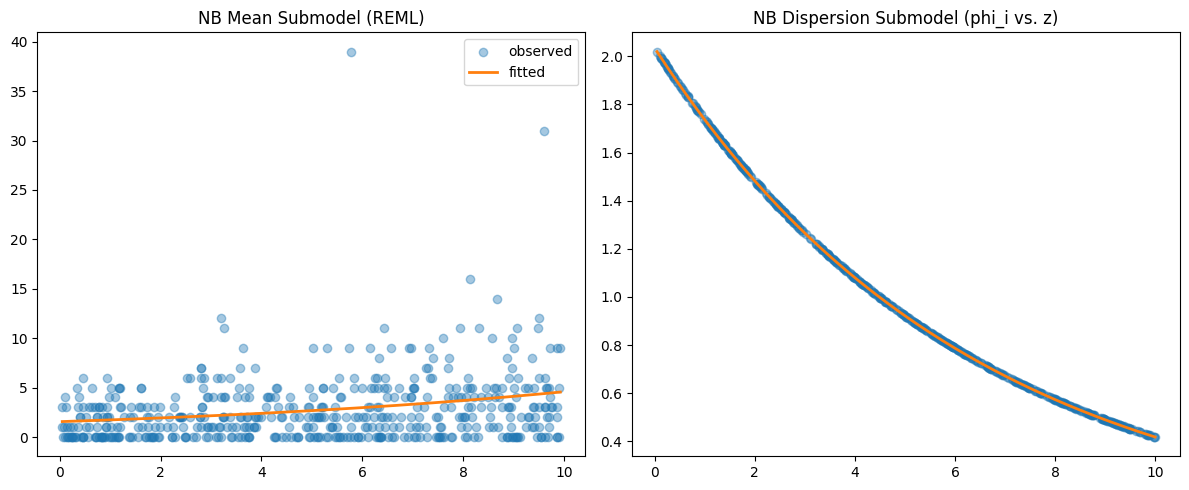

In [28]:
# Diagnostic plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Mean submodel
ax = axes[0]
ax.scatter(df['x'], df['y'], alpha=0.4, label='observed')
xx = np.linspace(df['x'].min(), df['x'].max(), 200)
mu_line = np.exp(mean_res.params['const'] + mean_res.params['x']*xx)
ax.plot(xx, mu_line, color='C1', lw=2, label='fitted')
ax.set_title("NB Mean Submodel (REML)")
ax.legend()

# Dispersion submodel
ax = axes[1]
ax.scatter(df['z'], phi_hat, alpha=0.4)
zz = np.linspace(df['z'].min(), df['z'].max(), 200)
phi_line = np.exp(gamma[0] + gamma[1]*zz)
ax.plot(zz, phi_line, color='C1', lw=2)
ax.set_title("NB Dispersion Submodel (phi_i vs. z)")

plt.tight_layout()
plt.show()